In [1]:
%load_ext autoreload
%autoreload 2

# Inverse problem for the diffusion-reaction system

Benchmark on the Inverse problem for the diffusion-reaction system as proposed in DeepXDE documentation: https://deepxde.readthedocs.io/en/latest/demos/pinn_inverse/reaction.inverse.html.


In [2]:
import numpy as np

# from PINNACLE
DEFAULT_NUM_DOMAIN_POINTS = 2000
DEFAULT_NUM_BOUNDARY_POINTS = 100
DEFAULT_NUM_INITIAL_POINTS = 100

def gen_traindata(lib):
    data = np.load("reaction.npz")
    t, x, ca, cb = data["t"], data["x"], data["Ca"], data["Cb"]
    X, T = np.meshgrid(x, t)
    X = np.reshape(X, (-1, 1))
    T = np.reshape(T, (-1, 1))
    Ca = np.reshape(ca, (-1, 1))
    Cb = np.reshape(cb, (-1, 1))
    if lib == "dde":
        return np.hstack((X, T)), Ca, Cb
    if lib == "jinns":
        return np.hstack((T, X)), np.hstack((Ca, Cb))

kf_init = 0.05
D_init = 1.

## DeepXDE


We use the tensorflow backend as JAX backend is not available

In [6]:
seed = 1

Compiling model...
'compile' took 0.004085 s

Training model...

0         [4.01e-04, 4.45e-02, 6.10e-01, 4.05e-01, 3.10e-02, 2.83e-02, 1.02e-01, 5.02e-01]    [3.80e-04, 4.26e-02, 6.10e-01, 4.05e-01, 3.10e-02, 2.83e-02, 1.02e-01, 5.02e-01]    []  
1000      [2.29e-04, 1.87e-04, 5.92e-04, 3.90e-04, 1.34e-03, 6.61e-04, 3.30e-04, 2.45e-04]    [1.78e-04, 1.45e-04, 5.92e-04, 3.90e-04, 1.34e-03, 6.61e-04, 3.30e-04, 2.45e-04]    []  
2000      [7.18e-05, 4.37e-05, 1.02e-04, 7.40e-05, 1.64e-04, 1.40e-04, 5.86e-05, 1.21e-04]    [5.34e-05, 3.49e-05, 1.02e-04, 7.40e-05, 1.64e-04, 1.40e-04, 5.86e-05, 1.21e-04]    []  
3000      [3.66e-05, 3.03e-05, 3.91e-05, 4.49e-05, 4.03e-05, 3.10e-05, 4.72e-05, 9.01e-05]    [2.99e-05, 2.63e-05, 3.91e-05, 4.49e-05, 4.03e-05, 3.10e-05, 4.72e-05, 9.01e-05]    []  
4000      [2.81e-05, 2.87e-05, 2.03e-05, 2.05e-05, 2.32e-05, 1.77e-05, 3.31e-05, 7.35e-05]    [2.45e-05, 2.43e-05, 2.03e-05, 2.05e-05, 2.32e-05, 1.77e-05, 3.31e-05, 7.35e-05]    []  
5000      [2.37e-05,

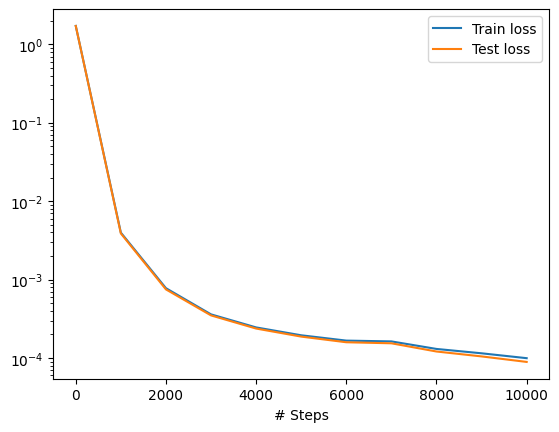

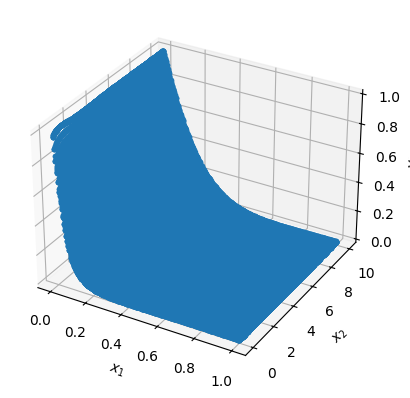

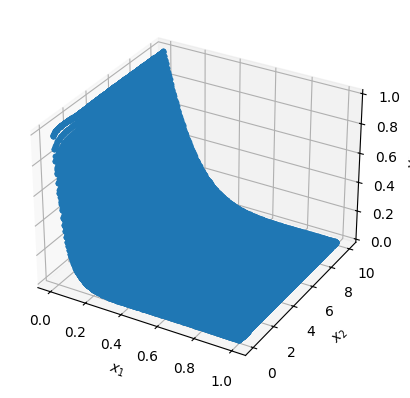

In [5]:
import os
os.environ["DDE_BACKEND"]="tensorflow"
import deepxde as dde

# Determinism may reduce performance in DeepXDE (see doc) but needs to
# be set for a fair comparison with Jinns
# https://deepxde.readthedocs.io/en/stable/modules/deepxde.html#deepxde.config.set_random_seed
dde.config.set_random_seed(seed)

kf = dde.Variable(kf_init)
D = dde.Variable(D_init)

def pde(x, y):
    ca, cb = y[:, 0:1], y[:, 1:2]
    dca_t = dde.grad.jacobian(y, x, i=0, j=1)
    dca_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    dcb_t = dde.grad.jacobian(y, x, i=1, j=1)
    dcb_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    eq_a = dca_t - 1e-3 * D * dca_xx + kf * ca * cb ** 2
    eq_b = dcb_t - 1e-3 * D * dcb_xx + 2 * kf * ca * cb ** 2
    return [eq_a, eq_b]


def fun_bc(x):
    return 1 - x[:, 0:1]


def fun_init(x):
    return np.exp(-20 * x[:, 0:1])


geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc_a = dde.icbc.DirichletBC(
    geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=0
)
bc_b = dde.icbc.DirichletBC(
    geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=1
)
ic1 = dde.icbc.IC(geomtime, fun_init, lambda _, on_initial: on_initial, component=0)
ic2 = dde.icbc.IC(geomtime, fun_init, lambda _, on_initial: on_initial, component=1)

observe_x, Ca, Cb = gen_traindata(lib="dde")
observe_y1 = dde.icbc.PointSetBC(observe_x, Ca, component=0)
observe_y2 = dde.icbc.PointSetBC(observe_x, Cb, component=1)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_a, bc_b, ic1, ic2, observe_y1, observe_y2],
    num_domain=2000,
    num_boundary=100,
    num_initial=100,
    anchors=observe_x,
    num_test=50000,
)
net = dde.nn.FNN([2] + [20] * 3 + [2], "tanh", "Glorot uniform")

model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[kf, D])
variable = dde.callbacks.VariableValue([kf, D], period=1000, filename="variables.dat")
losshistory, train_state = model.train(iterations=10000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## With Jinns

In [7]:
import jax
import equinox as eqx
import jinns
import jax.numpy as jnp
from jax import grad, vmap, random
import optax
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(seed)

2024-11-27 14:46:19.242178: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [8]:
eqx_list = (
    (eqx.nn.Linear, 2, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 2)
)
key, subkey = random.split(key)
u_pinn, init_nn_params_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

In [9]:
n = DEFAULT_NUM_DOMAIN_POINTS
ni = DEFAULT_NUM_INITIAL_POINTS
nb = DEFAULT_NUM_BOUNDARY_POINTS
dim = 1
xmin = 0
xmax = 1
tmin = 0
tmax = 10
method = "grid" # equals "uniform" in deepXDE, while "uniform" in jinns equals "pseudo" in deepXDE

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

In [10]:
# Init parameters for NN and equation
init_params_pinn = jinns.parameters.Params(
    nn_params=init_nn_params_pinn,
    eq_params={
        "D":jnp.array(D_init),
        "kf":jnp.array(kf_init)
    }
)

In [11]:
from jinns.loss import PDENonStatio

class DiffusionReaction(PDENonStatio):
    def equation(self, t_x, u, params):
        Ca = u(t_x, params)[0]
        Cb = u(t_x, params)[1]

        dC_dt = jax.jacrev(u)(t_x, params)[:, 0]
    
        lap = jinns.loss.vectorial_laplacian_rev(t_x, u, params, dim_out=2)
        return (dC_dt - params.eq_params["D"] * lap
                + jnp.array([params.eq_params["kf"] * Ca * Cb ** 2,
                             2 * params.eq_params["kf"] * Ca * Cb ** 2
                            ])
               )

dr_loss = DiffusionReaction()

In [12]:
def u0(x):
    init = jnp.exp(-20 * x)
    return jnp.array([init, init])

loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1, boundary_loss=1, observations=1
)

In [13]:
key, subkey = jax.random.split(key)
observe_t_x, Ca_Cb = gen_traindata(lib="jinns")

obs_data = jinns.data.DataGeneratorObservations(
    subkey,
    obs_batch_size=None,
    observed_pinn_in=observe_t_x,
    observed_values=Ca_Cb
)

In [14]:
derivative_keys = jinns.parameters.DerivativeKeysPDENonStatio.from_str(
    dyn_loss=jinns.parameters.Params(
        nn_params = True,
        eq_params = {
            'kf':True,
            'D':True
        }
    ),
    boundary_loss="nn_params",
    initial_condition="nn_params",
    observations="nn_params",
    params=init_params_pinn
)

In [15]:
loss_pinn = jinns.loss.LossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=dr_loss,
    derivative_keys=derivative_keys,
    omega_boundary_fun={"xmin":lambda t_dx: jnp.array([1, 1]),
                        "xmax": lambda t_dx: jnp.array([0, 0])
                       },
    omega_boundary_condition={"xmin":"dirichlet","xmax":"dirichlet"},
    initial_condition_fun=u0,
    params=init_params_pinn,
)

In [16]:
# Training loop in Jinns
params_pinn = init_params_pinn
tx = optax.adam(learning_rate=1e-3)
n_iter = 10000

In [17]:
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, stored_params, _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
    obs_data=obs_data,
    tracked_params = jinns.parameters.Params(
        eq_params={"D":True, "kf":True}
    ),
    verbose=True
)

(2,)
(2,)

Compilation took
 5.417473316192627 

[train] Iteration 0: loss value = 2.618346929550171
[train] Iteration 1000: loss value = 0.011576395481824875
[train] Iteration 2000: loss value = 0.0004924851236864924
[train] Iteration 3000: loss value = 0.00029687979258596897
[train] Iteration 4000: loss value = 0.0002158631250495091
[train] Iteration 5000: loss value = 0.00016652821796014905
[train] Iteration 6000: loss value = 0.00016203051200136542
[train] Iteration 7000: loss value = 0.00011802858352893963
[train] Iteration 8000: loss value = 0.00010918416955973953
[train] Iteration 9000: loss value = 8.633958350401372e-05

Stopping main optimization loop, cause: max iteration is reached

Training took
 34.23442625999451 


Final iteration 10000: train loss value = 8.033467020140961e-05


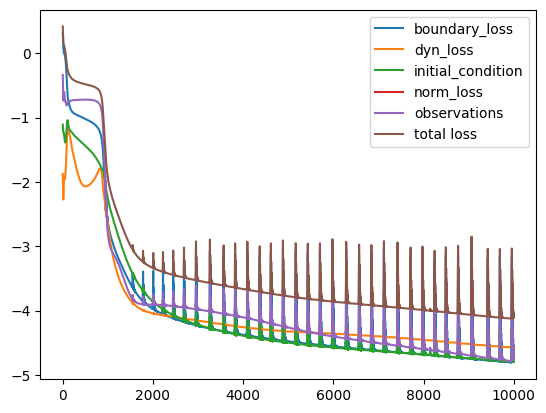

In [18]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

## Comparisons

In [19]:
print(f"{D_init=}, {kf_init=}")
print("According to DeepXDE doc, true D is D=0.002 and true kf=0.1")

D_init=1.0, kf_init=0.05
According to DeepXDE doc, true D is D=0.002 and true kf=0.1


In [22]:
print("DeepXDE (iteration, estimated kf, estimated D):")
with open('variables.dat') as f:
    for line in f:
        pass
    last_line = line
print(last_line)

DeepXDE (iteration, estimated kf, estimated D):
10000 [4.19e-02, 1.70e+00]



In [20]:
print("jinns: estimated D", stored_params.eq_params["D"][-1])
print("jinns: estimated kf", stored_params.eq_params["kf"][-1])

jinns: estimated D 0.0017474103
jinns: estimated kf 0.06923388
